In [17]:
import numpy as np
import torch
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = 10, 6

In [18]:
data_str = """
A transformer is a passive component that transfers electrical energy from one electrical circuit to another circuit, or multiple circuits. A varying current in any coil of the transformer produces a varying magnetic flux in the transformer's core, which induces a varying electromotive force (EMF) across any other coils wound around the same core. Electrical energy can be transferred between separate coils without a metallic (conductive) connection between the two circuits. Faraday's law of induction, discovered in 1831, describes the induced voltage effect in any coil due to a changing magnetic flux encircled by the coil.

Transformers are used to change AC voltage levels, such transformers being termed step-up or step-down type to increase or decrease voltage level, respectively. Transformers can also be used to provide galvanic isolation between circuits as well as to couple stages of signal-processing circuits. Since the invention of the first constant-potential transformer in 1885, transformers have become essential for the transmission, distribution, and utilization of alternating current electric power.[1] A wide range of transformer designs is encountered in electronic and electric power applications. Transformers range in size from RF transformers less than a cubic centimeter in volume, to units weighing hundreds of tons used to interconnect the power grid.
"""

# Clean dataset
data = data_str.replace("\n", "").split(" ")

# Create embedding dictionary
unique_data = list(set(data))
n_embedding = len(unique_data)
emb_dict = dict([(val, i) for i, val in enumerate(unique_data)])

# No. of unique words
n_embedding

131

In [19]:
class SelfAttentionWithEmbedding(torch.nn.Module):

    def __init__(self, n_init, n_embedding):
        super().__init__()

        self.scale = np.sqrt(n_init)
        
        self.Embedding = torch.nn.Embedding(n_embedding, n_init)
        
        self.Q = torch.nn.Linear(n_init, n_init)
        self.K = torch.nn.Linear(n_init, n_init)
        self.V = torch.nn.Linear(n_init, n_init)
        
        self.softmax = torch.nn.Softmax(dim=1)

        self.output = torch.nn.Linear(n_init**2, n_embedding)

    def forward(self, x):

        x_emb = self.Embedding(x)
        
        x_q = self.Q(x_emb)
        x_k = self.K(x_emb)
        x_v = self.V(x_emb)

        x_k_t = torch.transpose(x_k, 1, 2)
        
        output = self.softmax(torch.matmul(x_q, x_k_t) / self.scale)
        output = torch.matmul(output, x_v)
        output = torch.flatten(output, start_dim=1)

        output = self.output(output)

        return output

        

In [20]:
def create_dataset(data, n_seq=12):

    data_clear = data.replace("\n", "").split(" ")
    unique_data = list(set(data_clear))
    n_embedding = len(unique_data)
    emb_dict = dict([(val, i) for i, val in enumerate(unique_data)])
    data_emb = [emb_dict[i] for i in data_clear]
    
    dataset_emb = np.array([[k for k in data_emb[i:(i+n_seq)]] for i in range(len(data_emb) - n_seq - 1)])
    y = [d[-1] for d in dataset_emb[1:]]
    
    x = torch.from_numpy(np.array(dataset_emb[:-1]))
    y = torch.from_numpy(np.array(y, dtype='int64'))
    y_onehot = torch.nn.functional.one_hot(y, num_classes=n_embedding).type(torch.DoubleTensor)
    
    
    return torch.utils.data.TensorDataset(x, y_onehot)

    

In [21]:
# Create self attention layer with embeddings
layer = SelfAttentionWithEmbedding(12,  # Input sequence length
                                   n_embedding  # Embedding layer output no. dimensions & layer output no. dimensions
                                  )

# Create dataset from string data
dataset = create_dataset(data_str)

# Create pytorch model
model = torch.nn.Sequential()
model.add_module('fc1', layer)

# Create data loader
train_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

# Define loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Train for 100 epochs
for t in range(100):

    # Loss per epoch & no. of errors
    epoch_loss = 0
    errors = 0

    # For every batch
    for batch_idx, (x, y) in enumerate(train_loader):
        
        # Make predictions with the current parameters
        y_pred = model(x)
        
        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        
        # Add loss divided by number of samples per batch
        epoch_loss += torch.sum(loss) / 16
        
        # Add number or wrong predicted words
        errors += torch.sum(torch.argmax(y_pred, dim=1) != torch.argmax(y, dim=1))
        
        # Update the model's parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print loss and errors per epoch
    print(epoch_loss / (batch_idx + 1), 'errors:', errors)

tensor(0.3061, dtype=torch.float64, grad_fn=<DivBackward0>) errors: tensor(189)
tensor(0.3027, dtype=torch.float64, grad_fn=<DivBackward0>) errors: tensor(188)
tensor(0.3000, dtype=torch.float64, grad_fn=<DivBackward0>) errors: tensor(187)
tensor(0.2972, dtype=torch.float64, grad_fn=<DivBackward0>) errors: tensor(181)
tensor(0.2944, dtype=torch.float64, grad_fn=<DivBackward0>) errors: tensor(179)
tensor(0.2912, dtype=torch.float64, grad_fn=<DivBackward0>) errors: tensor(173)
tensor(0.2879, dtype=torch.float64, grad_fn=<DivBackward0>) errors: tensor(169)
tensor(0.2841, dtype=torch.float64, grad_fn=<DivBackward0>) errors: tensor(166)
tensor(0.2799, dtype=torch.float64, grad_fn=<DivBackward0>) errors: tensor(164)
tensor(0.2753, dtype=torch.float64, grad_fn=<DivBackward0>) errors: tensor(162)
tensor(0.2700, dtype=torch.float64, grad_fn=<DivBackward0>) errors: tensor(159)
tensor(0.2640, dtype=torch.float64, grad_fn=<DivBackward0>) errors: tensor(158)
tensor(0.2569, dtype=torch.float64, grad

In [22]:
# Print max values of model's predictions and targer for one batch 
torch.max(model[0].softmax(model(x)), dim=1), torch.argmax(y, dim=1)

(torch.return_types.max(
 values=tensor([0.9913, 0.9528, 0.9929, 0.9824, 0.9831, 0.9833, 0.9890, 0.9816, 0.9932,
         0.9778, 0.9681, 0.9889, 0.9880], grad_fn=<MaxBackward0>),
 indices=tensor([ 68, 124,  30,  90,  37,  53, 128, 111, 106,  88,  10,  69,  49])),
 tensor([ 68, 124,  30,  90,  37,  53, 128, 111, 106,  88,  10,  69,  49]))

In [23]:
# Single traing sample and label
x[0], torch.argmax(y[0])

(tensor([121,   3, 103,  61, 111, 124,  70,  30, 105,  76,  12,  53],
        dtype=torch.int32),
 tensor(68))

# Positional embedding layer

In [24]:
class PositinalEmbeddingLayer(torch.nn.Module):

    def __init__(self, seq_length, n_embedding):
        super().__init__()

        emb_arr = np.zeros((seq_length, n_embedding))

        for i in range(seq_length):
            for k in range(n_embedding):

                if k % 2 == 0:
                    emb_arr[i, k] = torch.sin(torch.Tensor([i / (10000**(k/n_embedding))]))
                else:
                    emb_arr[i, k] = torch.cos(torch.Tensor([i / (10000**((k - 1)/n_embedding))]))

        self.emb_arr = torch.Tensor(emb_arr)


    def forward(self, x):

        return x + self.emb_arr

        

In [25]:
PEL = PositinalEmbeddingLayer(12, 24)

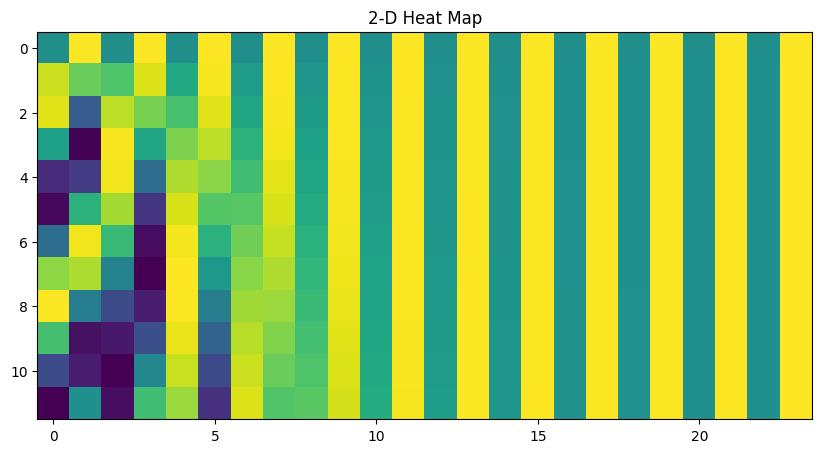

In [26]:
plt.imshow(PEL.emb_arr)
plt.title( "2-D Heat Map" )
plt.show()

## Train

In [27]:
class SelfAttention(torch.nn.Module):

    def __init__(self, n_init, n_seq, n_output):
        super().__init__()
        self.last_attention = None

        self.scale = np.sqrt(n_init)
        
        self.Q = torch.nn.Linear(n_init, n_seq)
        self.K = torch.nn.Linear(n_init, n_seq)
        self.V = torch.nn.Linear(n_init, n_init)
        
        self.softmax = torch.nn.Softmax(dim=1)

        self.output = torch.nn.Linear(n_init * n_seq, n_output)

    def forward(self, x):
        
        x_q = self.Q(x)
        x_k = self.K(x)
        x_v = self.V(x)

        x_k_t = torch.transpose(x_k, 1, 2)

        
        self.last_attention = self.softmax(torch.matmul(x_q, x_k_t) / self.scale)
        output = self.softmax(torch.matmul(x_q, x_k_t) / self.scale)
        output = torch.matmul(output, x_v)
        output = torch.flatten(output, start_dim=1)

        output = self.output(output)

        return output

        

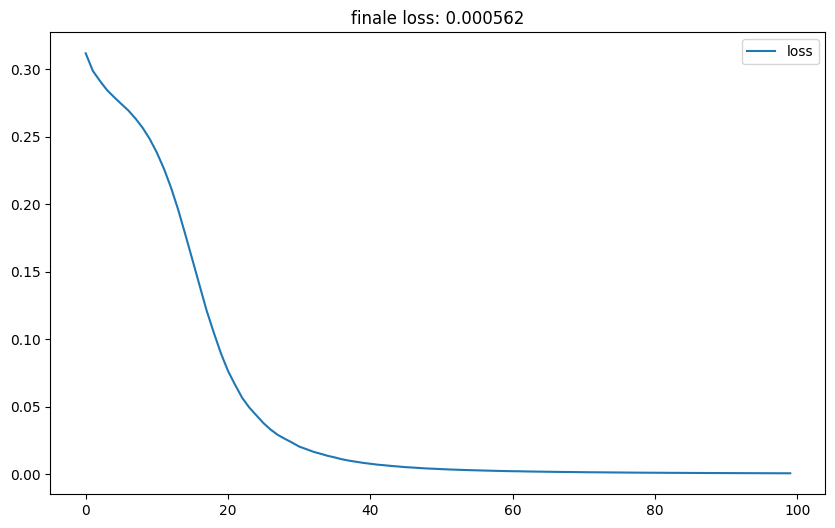

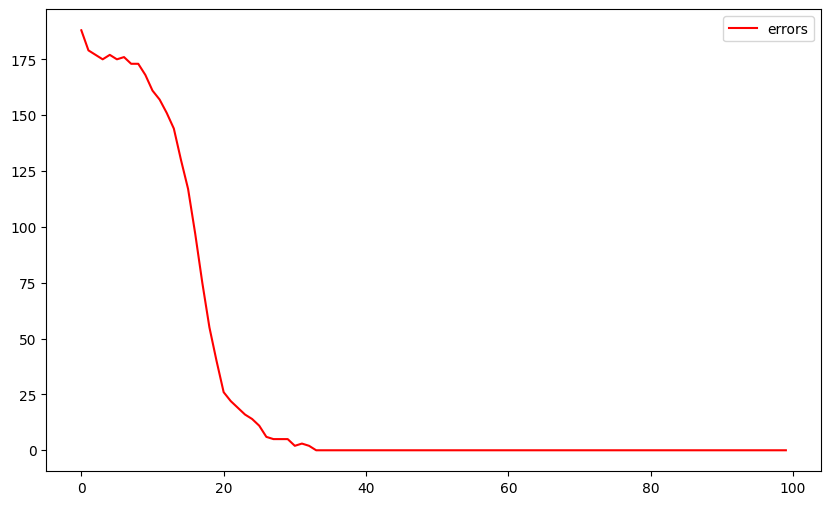

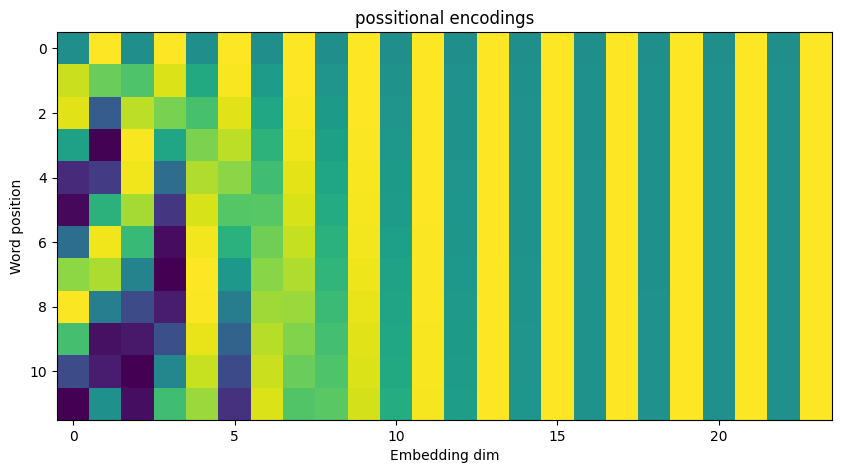

In [28]:
emb_dim = 24
seq_length = 12
batch_size = 16
epochs = 100

# Create dataset from string data
dataset = create_dataset(data_str, n_seq=seq_length)

# Create pytorch model
model = torch.nn.Sequential()
model.add_module('fc1', torch.nn.Embedding(n_embedding, emb_dim))
model.add_module('fc2', PositinalEmbeddingLayer(seq_length, emb_dim))
model.add_module('fc3', SelfAttention(emb_dim, seq_length, n_embedding))


# Create data loader
train_loader = torch.utils.data.DataLoader(dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

# Define loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

loss_arr = []
err_arr = []

# Train
for t in range(epochs):

    # Loss per epoch & no. of errors
    epoch_loss = 0
    errors = 0

    # For every batch
    for batch_idx, (x, y) in enumerate(train_loader):
        
        # Make predictions with the current parameters
        y_pred = model(x)
        
        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        
        # Add loss divided by number of samples per batch
        epoch_loss += torch.sum(loss)
        
        # Add number or wrong predicted words
        errors += torch.sum(torch.argmax(y_pred, dim=1) != torch.argmax(y, dim=1))
        
        # Update the model's parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print loss and errors per epoch
    # print(epoch_loss / (batch_idx + 1), 'errors:', errors)
    loss_arr.append((epoch_loss / len(dataset)).detach().numpy())
    err_arr.append(errors.numpy())

plt.plot(loss_arr, label='loss')
plt.legend(loc='upper right')
plt.title(f'finale loss: {loss_arr[-1]:.6f}')
plt.show()

plt.plot(err_arr, label='errors', color='red')
plt.legend(loc='upper right')
plt.show()

plt.imshow(model[1].emb_arr)
plt.xlabel('Embedding dim')
plt.ylabel('Word position')
plt.title("possitional encodings")
plt.show()

# Visualization of attention

In [29]:
data_clear = data_str.replace("\n", "").split(" ")
unique_data = list(set(data_clear))
n_embedding = len(unique_data)
emb_dict = dict([(val, i) for i, val in enumerate(unique_data)])
data_emb = [emb_dict[i] for i in data_clear]

In [30]:
emb_dict_rev = dict([(val, key) for key, val in emb_dict.items()])

def vect_to_word(vect):

    if type(vect) is torch.Tensor:
        new_vect = vect.numpy()
    else:
        new_vect = vect[:]
    
    return " ".join([emb_dict_rev[i] for i in new_vect])

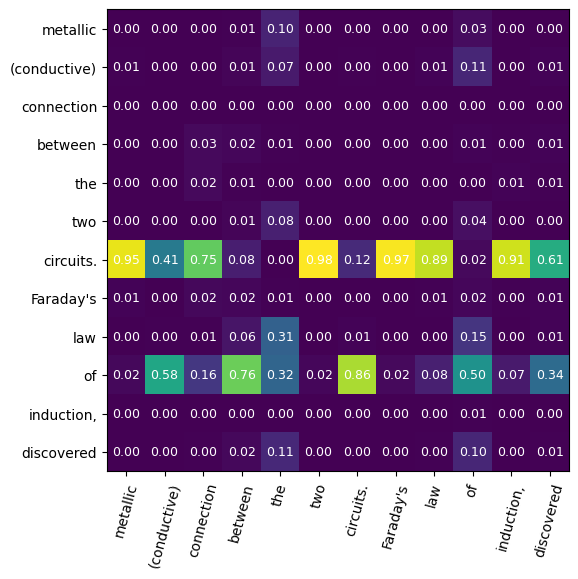

In [34]:

sample = dataset.tensors[0][64]
model(sample.reshape((1, -1)))
attention = model[2].last_attention[0].detach().numpy()

plt.imshow(attention, cmap='viridis')
plt.xticks(range(0, sample.shape[0]), labels=vect_to_word(sample).split(" "), rotation=75)
plt.yticks(range(0, sample.shape[0]), labels=vect_to_word(sample).split(" "))

for i in range(sample.shape[0]):
    for j in range(sample.shape[0]):
        plt.text(j, i, f'{attention[i, j]:.2f}', ha='center', va='center', color='w', fontsize=9)


plt.show()

# Sherlock

In [48]:
import requests
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import tqdm

nltk.download('punkt')

# Sherlock Holmes
url = "https://www.gutenberg.org/files/1661/1661-0.txt"
response = requests.get(url)
text = response.text

sentences = sent_tokenize(text)
tokens = [word_tokenize(sentence) for sentence in sentences]

cleaned_tokens = []
for sentence_tokens in tokens:
    cleaned_sentence = [word.lower() for word in sentence_tokens if word.isalpha()]
    cleaned_tokens.extend(cleaned_sentence)

cleaned_text = " ".join(cleaned_tokens)

cleaned_text = " ".join(cleaned_text.split())

print(cleaned_text[:1000]) 

n_chars = 50000
cleaned_text = cleaned_text[:n_chars]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hubert\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


ï project gutenberg ebook of the adventures of sherlock holmes by arthur conan doyle this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever you may copy it give it away or it under the terms of the project gutenberg license included with this ebook or online at if you are not located in the united states you will have to check the laws of the country where you are located before using this ebook title the adventures of sherlock holmes author arthur conan doyle release date november ebook most recently updated may language english character set encoding produced by an anonymous project gutenberg volunteer and jose menendez start of the project gutenberg ebook the adventures of sherlock holmes cover the adventures of sherlock holmes by arthur conan doyle contents i a scandal in bohemia ii the league iii a case of identity iv the boscombe valley mystery the five orange pips vi the man with t

Length of dataset: 9690


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:19<00:00, 15.99s/it]


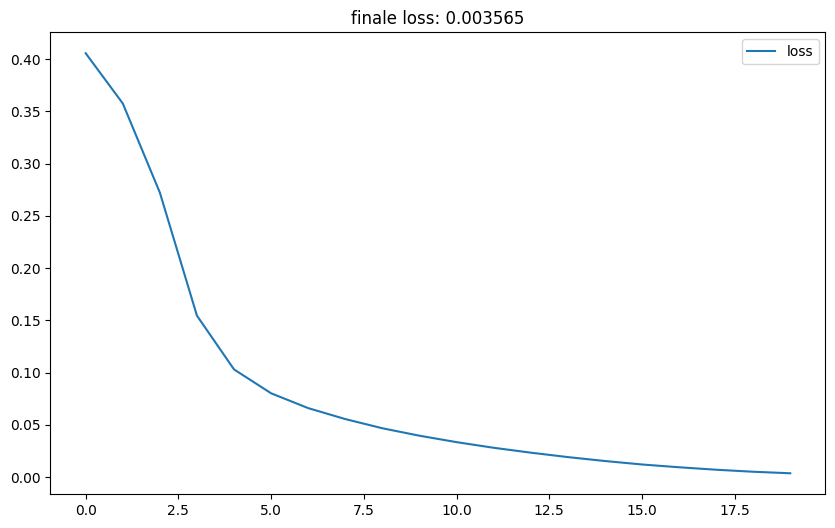

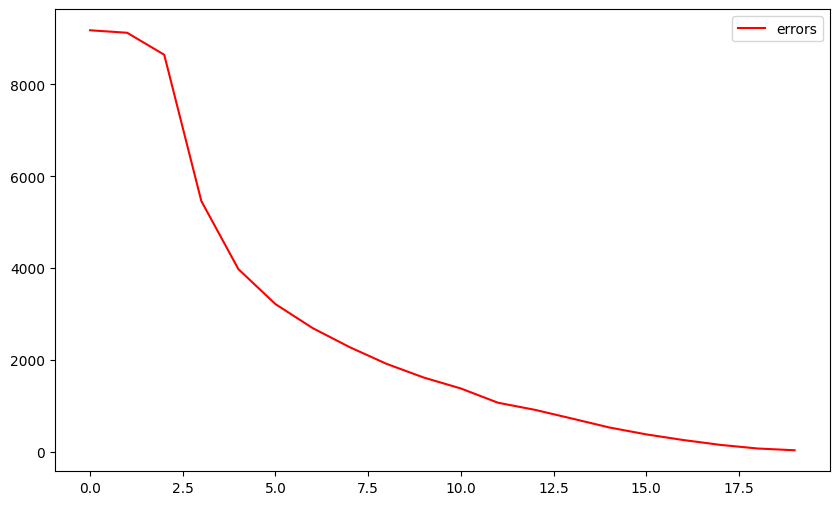

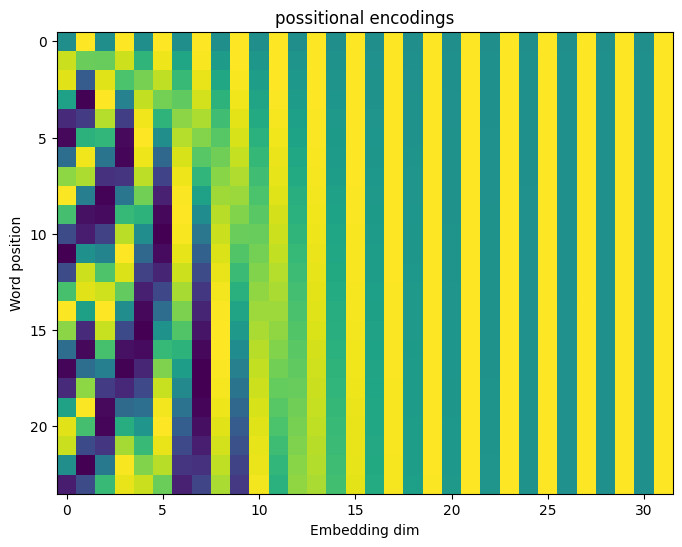

In [56]:
emb_dim = 32
seq_length = 24
batch_size = 16
epochs = 20

# Create dataset from string data
dataset = create_dataset(cleaned_text, n_seq=seq_length)

print('Length of dataset:', len(dataset.tensors[0]))

n_embedding = torch.max(dataset.tensors[0]).numpy() + 1

# Create pytorch model
model = torch.nn.Sequential()
model.add_module('fc1', torch.nn.Embedding(n_embedding, emb_dim))
model.add_module('fc2', PositinalEmbeddingLayer(seq_length, emb_dim))
model.add_module('fc3', SelfAttention(emb_dim, seq_length, n_embedding))


# Create data loader
train_loader = torch.utils.data.DataLoader(dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

# Define loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

loss_arr = []
err_arr = []

# Train
for t in tqdm.tqdm(range(epochs)):

    # Loss per epoch & no. of errors
    epoch_loss = 0
    errors = 0

    # For every batch
    for batch_idx, (x, y) in enumerate(train_loader):
        
        # Make predictions with the current parameters
        y_pred = model(x)
        
        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        
        # Add loss divided by number of samples per batch
        epoch_loss += torch.sum(loss)
        
        # Add number or wrong predicted words
        errors += torch.sum(torch.argmax(y_pred, dim=1) != torch.argmax(y, dim=1))
        
        # Update the model's parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print loss and errors per epoch
    # print(epoch_loss / (batch_idx + 1), 'errors:', errors)
    loss_arr.append((epoch_loss / len(dataset)).detach().numpy())
    err_arr.append(errors.numpy())

plt.plot(loss_arr, label='loss')
plt.legend(loc='upper right')
plt.title(f'finale loss: {loss_arr[-1]:.6f}')
plt.show()

plt.plot(err_arr, label='errors', color='red')
plt.legend(loc='upper right')
plt.show()

plt.imshow(model[1].emb_arr)
plt.xlabel('Embedding dim')
plt.ylabel('Word position')
plt.title("possitional encodings")
plt.show()

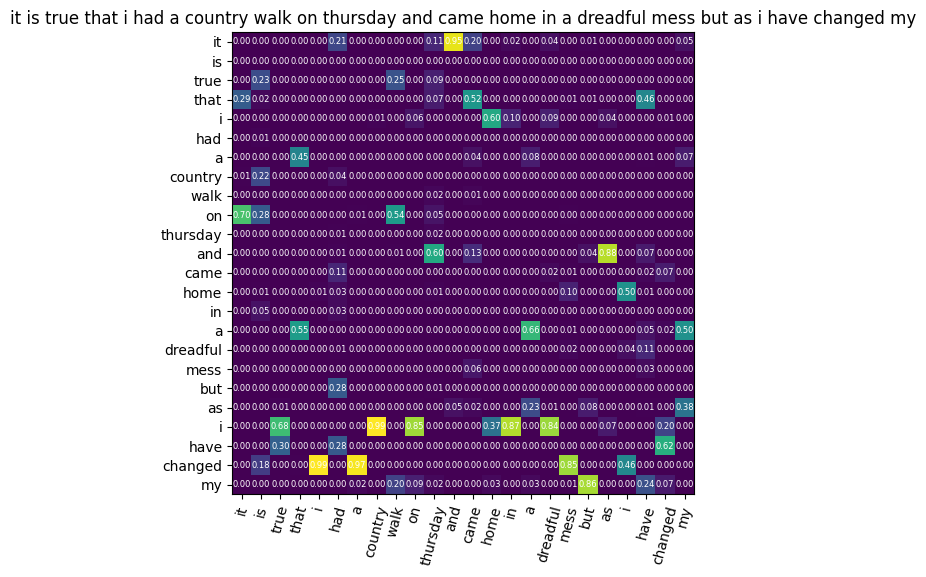

In [60]:
data_clear = cleaned_text.replace("\n", "").split(" ")
unique_data = list(set(data_clear))
n_embedding = len(unique_data)
emb_dict = dict([(val, i) for i, val in enumerate(unique_data)])
data_emb = [emb_dict[i] for i in data_clear]
emb_dict_rev = dict([(val, key) for key, val in emb_dict.items()])



sample_no = 1000
sample = dataset.tensors[0][sample_no]
model(sample.reshape((1, -1)))
attention = model[2].last_attention[0].detach().numpy()

plt.imshow(attention, cmap='viridis')
plt.xticks(range(0, sample.shape[0]), labels=vect_to_word(sample).split(" "), rotation=75)
plt.yticks(range(0, sample.shape[0]), labels=vect_to_word(sample).split(" "))
plt.title(vect_to_word(sample))

for i in range(sample.shape[0]):
    for j in range(sample.shape[0]):
        plt.text(j, i, f'{attention[i, j]:.2f}', ha='center', va='center', color='w', fontsize=6)


plt.show()

In [59]:
err_arr[-1]

array(36, dtype=int64)